 #### Overview
The exercise below checked the behaviour of two machine learning algorithms one with a long term memory(LSTM stateful) versus another with no long term memory(LSTM stateless) on foreign exchange data. The original LSTM model was first proposed by Hochreiter,S & Schmidhuber J (1997) and since then several adjustments and refinements have taken place with the model. It has become one of the more popular neural network algorithms for modelling sequences whether that be sequences of words in natural language processing or sequences of observations in financial time series modelling(1,3).  

The data was sourced from the RBA public repositories and consists of daily closing spot rates for the Australian Dollar/US Dollar(AUDUSD) cross. 

The two models(Stateful and Stateless) are tested on their ability to predict or forecast next day FX rates. In one case the unseen data represented a sudden break in the trend compared to the data both models were trained on and in the other case both models were shown a block of unseen data that was still within the trend again compared to the data both models were trained on.  

 
#### Model behaviour
At low epochs the models behaved for the most part as one would expect. Models with the longest memory and where autocorrelation was present did not do well when the trend suddenly changed. Models with the shortest memory were more adaptable to a trend change which is not surprising.

Autocorrelation and the presence of statistical covariance between the time steps(residuals) affected the memory cells of the stateful model to the point where it really helped if the model was asked to predict in-trend unseen data but it also really negatively impacted the performance on unseen data when that data represented a break in trend. 

At higher epochs the models converged both in terms of lower RMSE's but also converged on each other in terms of relative performance. It was still the case that the error was relatively high on a break in trend and where autocorrelation was present in training. It is acknowledged that differencing helps to neutralise the issue of autocorrelation but the interest was more around model performance on absolute FX rates when trends change or stay in tact.  

#### Background
The idea wasn't to necessarily minimise the chosen error metric which was the Mean Squared Error(MSE). Rather it was to compare the relative error terms(RMSE) between the two LSTM models under different circumstances. Some of the errors were at the persistence model level and some outperformed the persistence model. Raw data was differenced on each run. All data was scaled(-1,+1). Batch size was set at one for both models. The predictor matrix was set at (n_samples,one time step and one dimension) for both models. Neurons were set at one across each layer of both neural network models.  

      
#### References. 
 
1. Bao,W ,Yue,J , Rao,Y(2017). A deep learning framework for financial time series using stacked autoencoders and long-short term memory,PLoS ONE 12(7).

2. Hochreiter,S ,Schmidhuber J (1997). "Long short-term memory". Neural Computation. 9 (8): 1735–1780.
 
3. Namin A.S, Namin S.S (2018),Forecasting Economic and financial time series: ARIMA VS. LSTM, Texas Tech University.

#### Nov/2018

In [1]:
#Randoms 
import sys
import sched
import time
from datetime import datetime as dt
import datetime
import time

#Pandas
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat

#Numpy
import numpy as np

#Tensorflow backend and keras 
import tensorflow 
import keras
from keras.layers import RepeatVector
from keras import losses
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras import regularizers
from keras import optimizers
from keras.layers import Dropout, Input
from keras.layers.noise import GaussianNoise
from keras.callbacks import ModelCheckpoint

#SK learn
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
 
#Plot
import matplotlib  
import matplotlib.pyplot as plt 

Using TensorFlow backend.


In [2]:
#Functions 
#Plot function
def plot_data(self): 
    fig, [ax1,ax2] = plt.subplots(2,1,sharex=False)
    ax1.set_title('AUDUSD chart')
    ax1.plot(self)
    ax1.grid(True)
    ax1.set_xlabel('Time')
    ax2.set_title('Autocorrelation plot')
    ax2.acorr(self, usevlines=False, normed=True, maxlags=100, lw=2)
    ax2.grid(True)
    ax2.axhline(0, color='blue', lw=0.5)
    ax2.set_xlabel('Lags')
    fig.tight_layout()
    plt.show()
    
#Differencing function    
def  difference_data(self): 
    X_diff=Series(np.diff(self,axis=0))
    return X_diff

#Lag data by one period(day)
def shift_values(self):
    values = DataFrame(self.values)
    dataframe_1 = concat([values.shift(1),values], axis=1)
    dataframe_1.columns = ['change(t-1)','change(t)']
    X_shift= dataframe_1.dropna(inplace=False)
    return X_shift 

#Split data into train/test(90/10)
def split_data(self):
    size = int(len(self) * 0.9)
    train, test = self[0:size], self[size:len(self)]
    return train,test

#Scale data to -1/1 range 
def scale_data(train,test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_s = scaler.transform(train)
    test_s = scaler.transform(test)
    return train_s,test_s


#Stateful model: batch size =1, dim=1,neurons=1
#Compile stateful model
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons): 
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])     
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')     
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
        model.reset_states()
    return model 

#check baseline
def model_persistence(self):
    return self


#Store predictions from stateful model
def forecast_lstm(model, X, n_batch):    
    X = X.reshape(1, 1, len(X))     
    forecast = model.predict(X, batch_size=n_batch)    
    return [x for x in forecast[0, :]] 

#Run predictions on test data
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]        
        forecast = forecast_lstm(model, X, n_batch)        
        forecasts.append(forecast)
    return forecasts

#Print error of stateful model
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('Error(Long term Memory on): %f' % ( rmse))
        
#Stateless model: batch size =1, dim=1 ,neurons=1
#Compile stateless model
def fit_lstm_stateless(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons): 
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1]) 
    model_sl = Sequential()
    model_sl.add(LSTM(n_neurons, input_shape=(1,1)))
    model_sl.add(Dense(y.shape[1]))
    model_sl.compile(loss='mean_squared_error', optimizer='adam')   
    history = model_sl.fit(X, y, epochs=nb_epoch, batch_size=n_batch, verbose=0, shuffle=False)                
    return model_sl
     
#Store predictions from stateless model
def forecast_lstm_stateless(model, X, n_batch):  
    X = X.reshape(1, 1, len(X))    
    forecast = model.predict(X, batch_size=n_batch)    
    return [x for x in forecast[0, :]]

#Run predictions on test data 
def make_forecasts_stateless(model, n_batch, train, test, n_lag, n_seq):
    forecasts_s = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]        
        forecast = forecast_lstm_stateless(model, X, n_batch)      
        forecasts_s.append(forecast)
    return forecasts_s

#Print error of stateless model
def evaluate_forecasts_stateless(test, forecasts_s, n_lag, n_seq):
    for i in range(n_seq):
        actual = [row[i] for row in test]
        predicted = [forecast[i] for forecast in forecasts_s]
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        print('Error(Long Term Memory off): %f' % ( rmse))
        
#Execute plot and stateful model(lags=1 epochs=5, batch=1,neurons=1 ) on  
#non-differenced and differenced data. 
def run_models(self):    
    plot_data(self)
    print("RMSE's : without differencing")
    X_shift = shift_values(self)
    train,test= split_data(X_shift)
    train_s,test_s = scale_data(train,test) 
    model =fit_lstm(train_s, 1, 1, 1, 5, 1)
    forecasts= make_forecasts(model, 1, train_s, test_s, 1, 1)
    evaluate_forecasts(test_s, forecasts, 1, 1)    
    model_sl= fit_lstm_stateless(train_s, 1, 1, 1, 5, 1)    
    forecasts_s= make_forecasts_stateless(model_sl, 1, train_s, test_s, 1, 1)     
    evaluate_forecasts_stateless(test_s, forecasts_s, 1, 1)
        
#Execute plot and stateless model(lags=1 epochs=5, batch=1,neurons=1) on 
#non-differenced and differenced data. 
def run_models_diff(self):    
    print( "RMSE's : with differencing")
    X_diff= difference_data(self)
    X_shift = shift_values(X_diff)     
    train,test= split_data(X_shift)
    train_s,test_s = scale_data(train,test)       
    model = fit_lstm(train_s, 1, 1, 1, 5, 1)
    forecasts = make_forecasts(model, 1, train_s, test_s, 1, 1)
    evaluate_forecasts(test_s, forecasts, 1, 1)    
    model_sl = fit_lstm_stateless(train_s, 1, 1, 1, 5, 1)     
    forecasts_s = make_forecasts_stateless(model_sl, 1, train_s, test_s, 1, 1)     
    evaluate_forecasts_stateless(test_s, forecasts_s, 1, 1)       

### READ IN COMPLETE DATA SET. SPLIT DATA  INTO FOUR SLICES FOR TESTING BELOW.

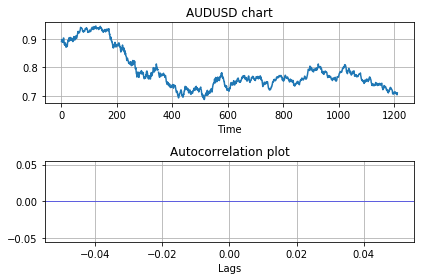

In [3]:
#Read in entire data set and check for autocorrelation across entire data set.
audusd = pd.read_csv('....rba_audusd.csv') 
total_data=(audusd['audusd'])
plot_data(total_data)

### (i) DATA SLICE WITH NO AUTOCORRELATION PRESENT AND TEST DATA IS A BREAK IN TREND.

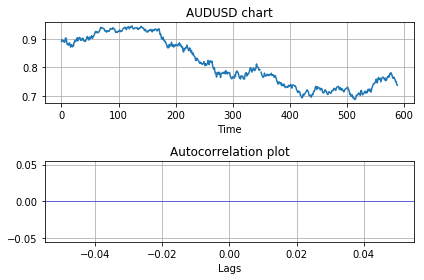

In [4]:
#Slice of data with no autocorrelation(training) and trend break just after
#observation 500. 
X1 = pd.Series(audusd['audusd'].iloc[0:590])
run_models(X1)
run_models_diff(X1)

|      RMSE                      |    5 epochs  |  50 epochs   |  100 epochs  | 200 epochs   | 400 epochs   |
|-------------------------------:|:------------:|:------------:|:------------:|:------------:|:------------:|
|NO DIFFERENCING                 |              |              |              |              |              |
|Long term memory on             |    0.188553  |     0.095756 |     0.046719 |     0.031180 |   0.050924   |
|Long term memory off            |    0.093626  |     0.042108 |     0.044195 |     0.040575 |   0.040575   |
|                                                           
|WITH DIFFERENCING               |              |              |              |              |              |
|Long term memory on             |    0.407307  |     0.433719 |     0.437105 |     0.440056 |   0.442412   |
|Long term memory off            |    0.405194  |     0.435369 |     0.433027 |     0.433900 |   0.436617   |         

### (ii) DATA SLICE WITH NO AUTOCORRELATION PRESENT AND TEST DATA IS IN-TREND. 

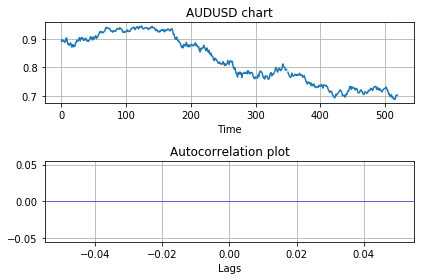

In [5]:
#Slice two of data with no autocorrelation(training) and trend in tact on unseen data.
X2 = pd.Series(audusd['audusd'].iloc[0:520]) 
run_models(X2)
run_models_diff(X2)

|    RMSE             |  5 epochs  | 50 epochs  | 100 epochs | 200 epochs | 400 epochs |
|--------------------:|:----------:|:----------:|:----------:|:----------:|:----------:|
|NO DIFFERENCING      |            |            |            |            |            |
|Long term memory on  |    0.235145|    0.097186|   0.057491 |    0.026879|  0.048315  |
|Long term memory off |    0.200616|    0.034422|   0.030387 |    0.025857|  0.025825  |
|                     |            |            |            |            |            |
|WITH DIFFERENCING    |            |            |            |            |            |
|Long term memory on  |    0.365208|    0.339851|   0.346298 |    0.346453|  0.348004  |
|Long term memory off |    0.339372|    0.344973|   0.343274 |    0.344493|  0.345573  |                   

### (iii) DATA SLICE WITH AUTOCORRELATION PRESENT AND TEST DATA IS A BREAK IN TREND.

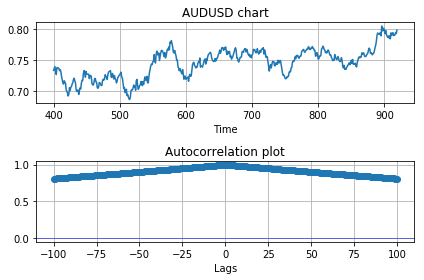

In [6]:
#Slice three of data with autocorrelation(training) and trend break around time period 870.
X3 = pd.Series(audusd['audusd'].iloc[400:920]) 
run_models(X3)
run_models_diff(X3)

|    RMSE              |   5 epochs  |  50 epochs  |  100 epochs | 200 epochs  | 400 epochs  |
|---------------------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|
|NO DIFFERENCING       |             |             |             |             |             |
|Long term memory on   |    0.535394 |     0.261859|     0.282045|     0.182983|  0.168273   |
|Long term memory off  |    0.286039 |     0.225433|     0.265688|     0.213567|  0.201675   |
|                      |             |             |             |             |             |
|WITH DIFFERENCING     |             |             |             |             |             |
|Long term memory on   |    0.287971 |     0.292457|     0.287836|     0.287796| 0.294076    |
|Long term memory off  |    0.280028 |     0.287934|     0.292131|     0.293715| 0.293449    |

### (iv) DATA SLICE WITH AUTOCORRELATION PRESENT AND TEST DATA IS IN-TREND.

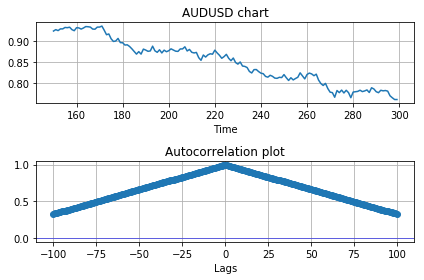

In [7]:
#Slice four of data with autocorrelation(training) and trend in tact on unseen data.
X4 = pd.Series(audusd['audusd'].iloc[150:300]) 
run_models(X4)
run_models_diff(X4)

|    RMSE               |    5 epochs |    50 epochs|   100 epochs| 200 epochs  |400 epochs   |
|----------------------:|:-----------:|:-----------:|:-----------:|:-----------:|:-----------:|
|NO DIFFERENCING        |             |             |             |             |             |
|Long term memory on    |    0.291617 |     0.168186|     0.101612|     0.075390|0.058256     |
|Long term memory off   |    0.883501 |     0.078292|     0.067172|     0.034324|0.023677     |
|                       |             |             |             |             |             |
|WITH DIFFERENCING      |             |             |             |             |             | 
|Long term memory on    |    0.394246 |     0.438304|     0.443075|     0.451573|0.423370     |
|Long term memory off   |    0.286071 |     0.437033|     0.448237|     0.456656|0.453998     |